In [ ]:
!pip install ultralytics

In [ ]:
!pip install -U ipywidgets

In [ ]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from glob import glob

from PIL import Image


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tentukan path ke folder "Car Detection" di Google Drive
drive_path = "/content/drive/My Drive/Car Detection"

# Pastikan folder "Car Detection" ada, jika tidak maka buat
os.makedirs(drive_path, exist_ok=True)
print(f"Google Drive is mounted, and files will be saved to: {drive_path}")

Google Drive is mounted, and files will be saved to: /content/drive/My Drive/Car Detection


In [ ]:
import os
from PIL import Image

# Path ke folder gambar
train_images_path = "/content/drive/My Drive/Car Detection/training_images"

# List beberapa gambar
image_files = os.listdir(train_images_path)[:5]

# Tampilkan salah satu gambar
image_path = os.path.join(train_images_path, image_files[0])
image = Image.open(image_path)
image.show()

In [ ]:
gdrive_dir = "/content/drive/My Drive/Car Detection"

# Buat struktur direktori
os.makedirs(f"{gdrive_dir}/images/train", exist_ok=True)
os.makedirs(f"{gdrive_dir}/images/val", exist_ok=True)
os.makedirs(f"{gdrive_dir}/labels/train", exist_ok=True)
os.makedirs(f"{gdrive_dir}/labels/val", exist_ok=True)

print(f"Struktur direktori berhasil dibuat di: {gdrive_dir}")

Struktur direktori berhasil dibuat di: /content/drive/My Drive/Car Detection


In [ ]:
# Define paths
root_dir = "/content/drive/MyDrive/Car Detection"
labels_dir = "/content/drive/MyDrive/Car Detection/labels"
images_dir = "/content/drive/MyDrive/Car Detection/images"
train_data = "/content/drive/MyDrive/Car Detection/training_images"
csv_data = "/content/drive/MyDrive/Car Detection/train_solution_bounding_boxes.csv"
test_data = "/content/drive/MyDrive/Car Detection/testing_images"

In [ ]:
# Loading the CSV data
df = pd.read_csv(csv_data)

# Display the first few rows of the dataframe to understand its structure
df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB
None


In [ ]:
# Visualizing sample images with bounding boxes
def plot_images_with_boxes(image_path, df, n=5):
    images = glob(f'{image_path}/*.jpg')[:n]
    for img_path in images:
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        boxes = df[df['image'] == img_name]

        for _, box in boxes.iterrows():
            cv2.rectangle(img,
                          (int(box['xmin']), int(box['ymin'])),
                          (int(box['xmax']), int(box['ymax'])),
                          (0, 255, 0), 2)

        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_name)
        plt.axis('off')
        plt.show()

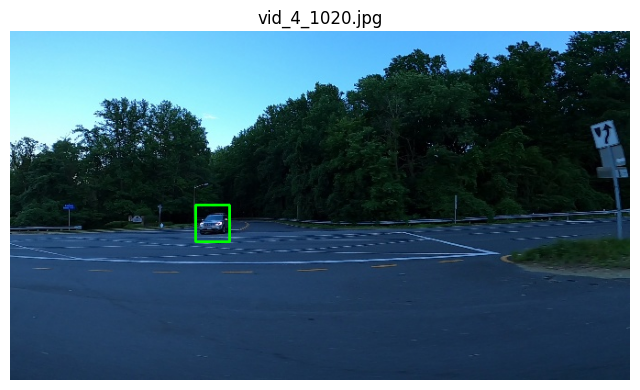

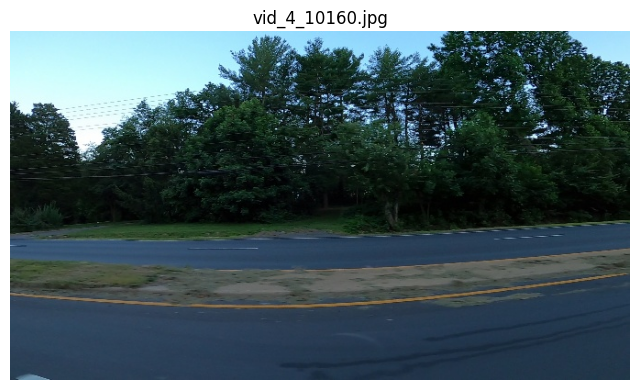

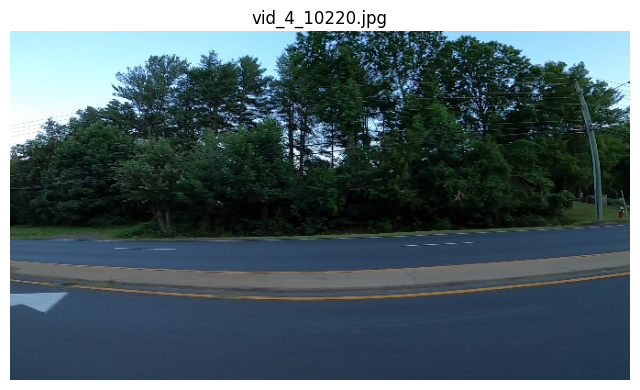

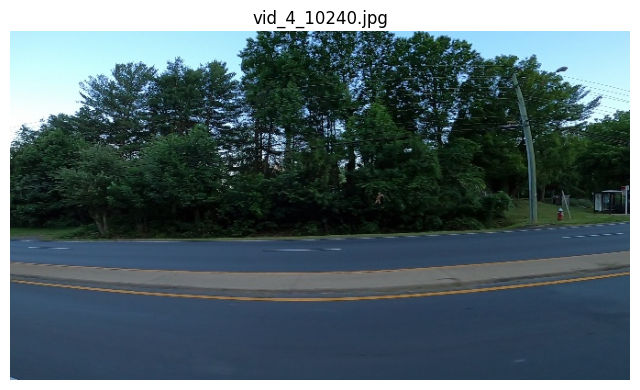

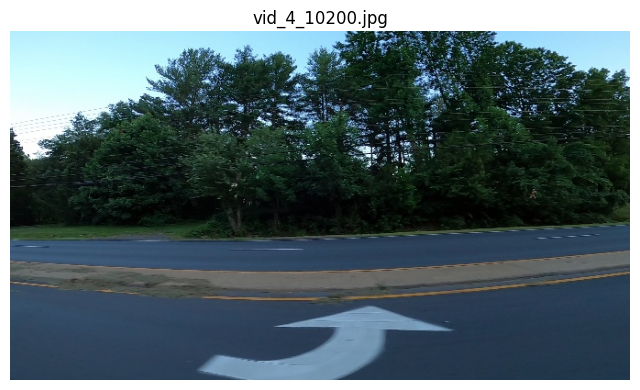

In [ ]:
# Plotting sample images with bounding boxes
plot_images_with_boxes(train_data, df)

# Preparing the Dataset for YOLO

In [ ]:
# Prepare YOLO format annotations
def create_yolo_annotation(row, img_width, img_height):
    x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
    y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
    width = (row['xmax'] - row['xmin']) / img_width
    height = (row['ymax'] - row['ymin']) / img_height
    return f"0 {x_center} {y_center} {width} {height}"

In [ ]:
# Create YOLO annotations and copy images
for img_name in df['image'].unique():
    img_df = df[df['image'] == img_name]
    img_path = os.path.join(train_data, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img_height, img_width = img.shape[:2]

        # Decide whether to put in train or val folder
        if np.random.rand() < 0.8:  # 80% train, 20% val
            subset = "train"
        else:
            subset = "val"

        # Copy image
        dst_img_path = os.path.join(images_dir, subset, img_name)
        cv2.imwrite(dst_img_path, img)

        # Create annotation file
        annotation_path = os.path.join(labels_dir, subset, f"{img_name.split('.')[0]}.txt")
        with open(annotation_path, 'w') as f:
            for _, row in img_df.iterrows():
                yolo_annotation = create_yolo_annotation(row, img_width, img_height)
                f.write(yolo_annotation + '\n')

In [ ]:
# Create YAML configuration file
yaml_content = f"""
path: {root_dir}
train: images/train
val: images/val

nc: 1
names: ['car']
"""

with open('car_detection.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML configuration file created.")

YAML configuration file created.


In [ ]:
# salin ke Google Drive
!cp /content/car_detection.yaml /content/drive/MyDrive/Car Detection

cp: target 'Detection' is not a directory


In [ ]:
!yolo task=detect mode=train data=/content/car_detection.yaml model=yolo11n.pt epochs=100 imgsz=640

100% 5.35M/5.35M [00:00<00:00, 96.3MB/s]
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/car_detection.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

In [ ]:
!yolo task=detect mode=val data=/content/car_detection.yaml model=/content/runs/detect/train/weights/best.pt

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/drive/MyDrive/Car Detection/labels/val.cache... 61 images, 0 backgrounds, 0 corrupt: 100% 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:01<00:00,  2.04it/s]
                   all         61        112      0.991          1      0.995      0.714
Speed: 1.2ms preprocess, 8.7ms inference, 0.0ms loss, 10.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


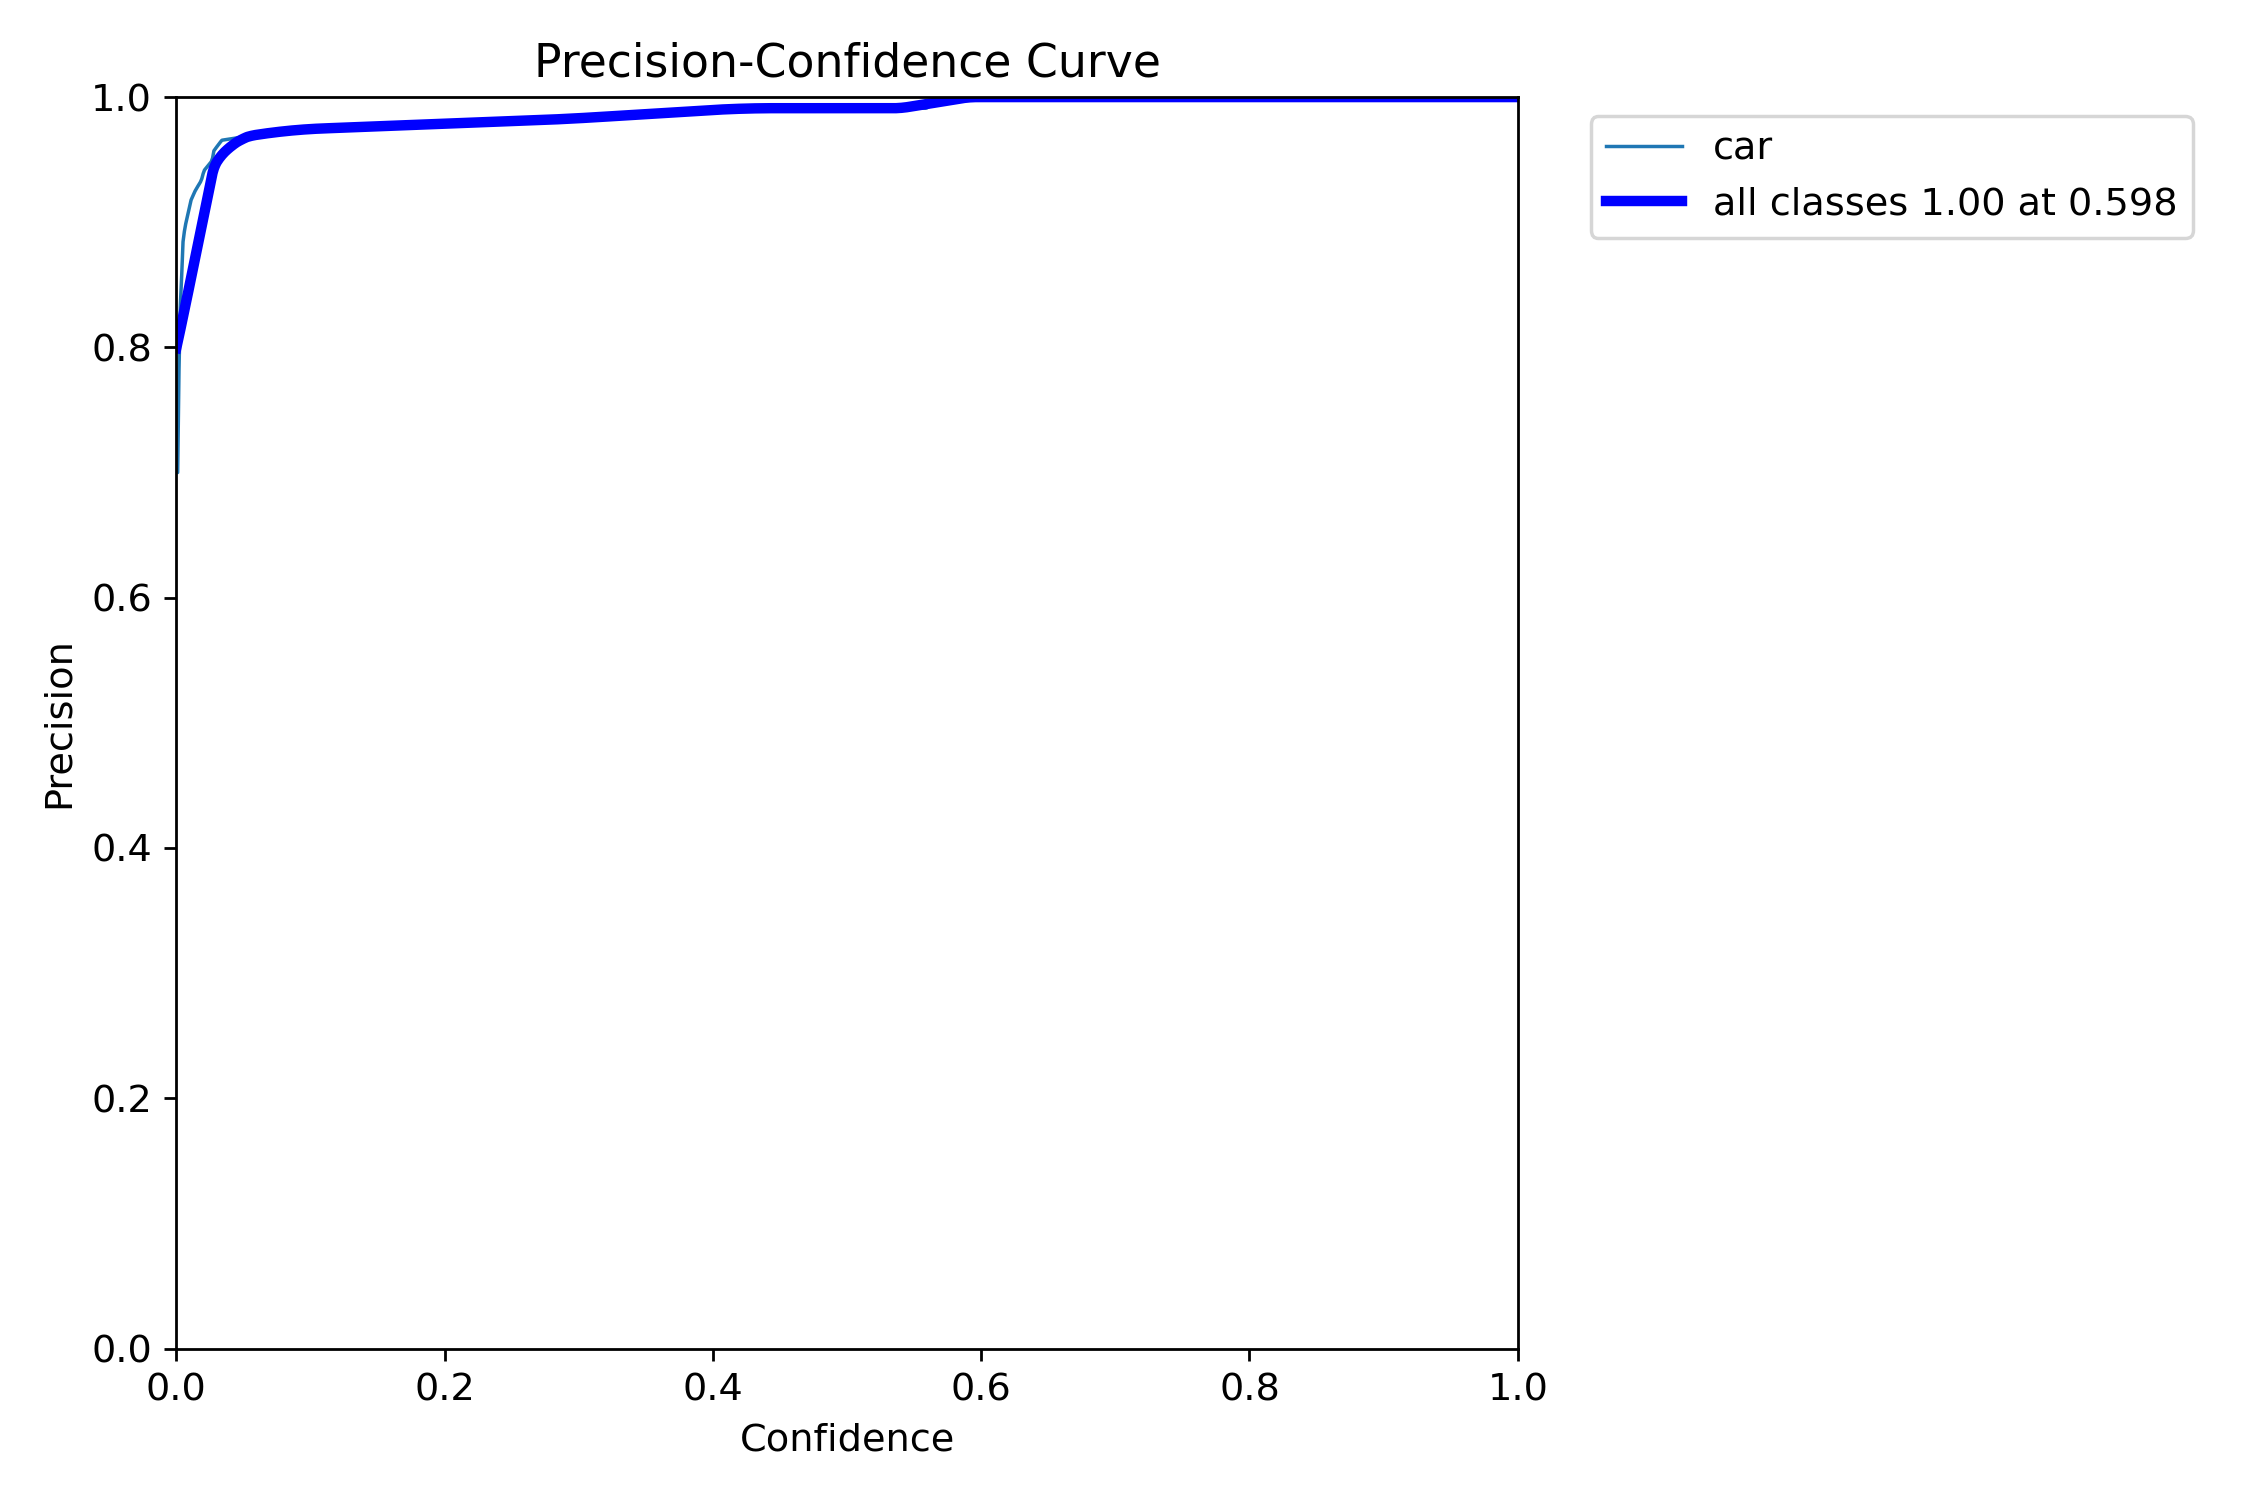

In [ ]:
Image("/content/runs/detect/train/P_curve.png", width=600)

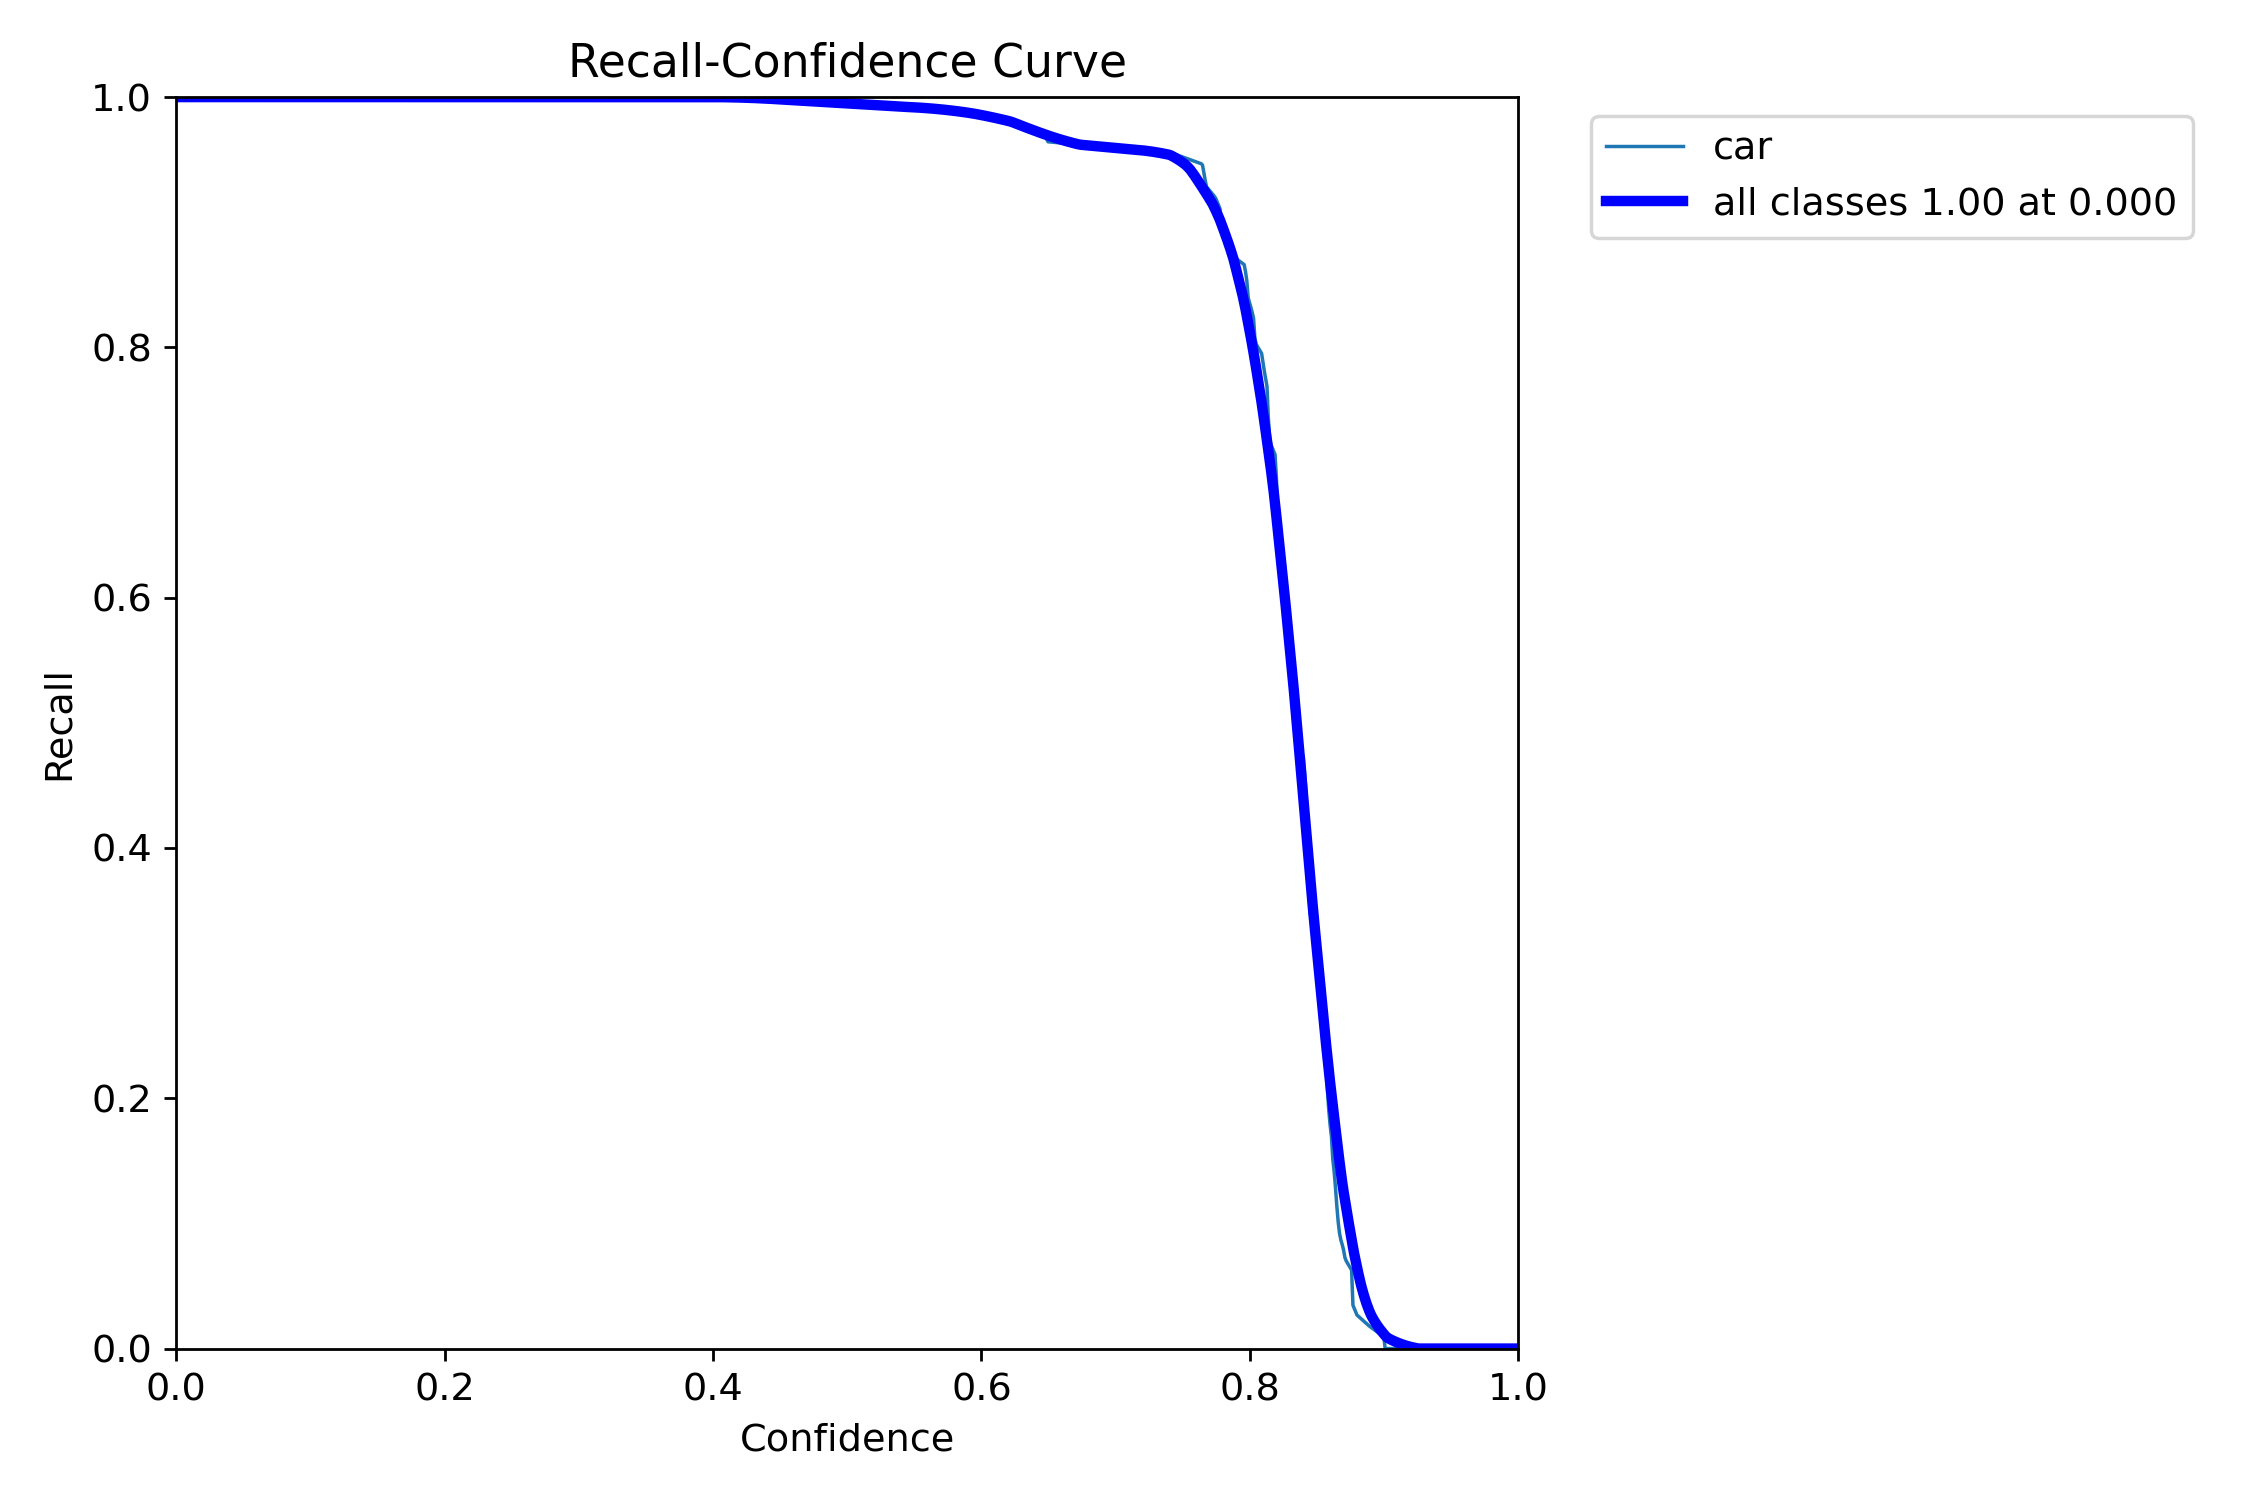

In [ ]:
Image("/content/runs/detect/train/R_curve.png", width=600)

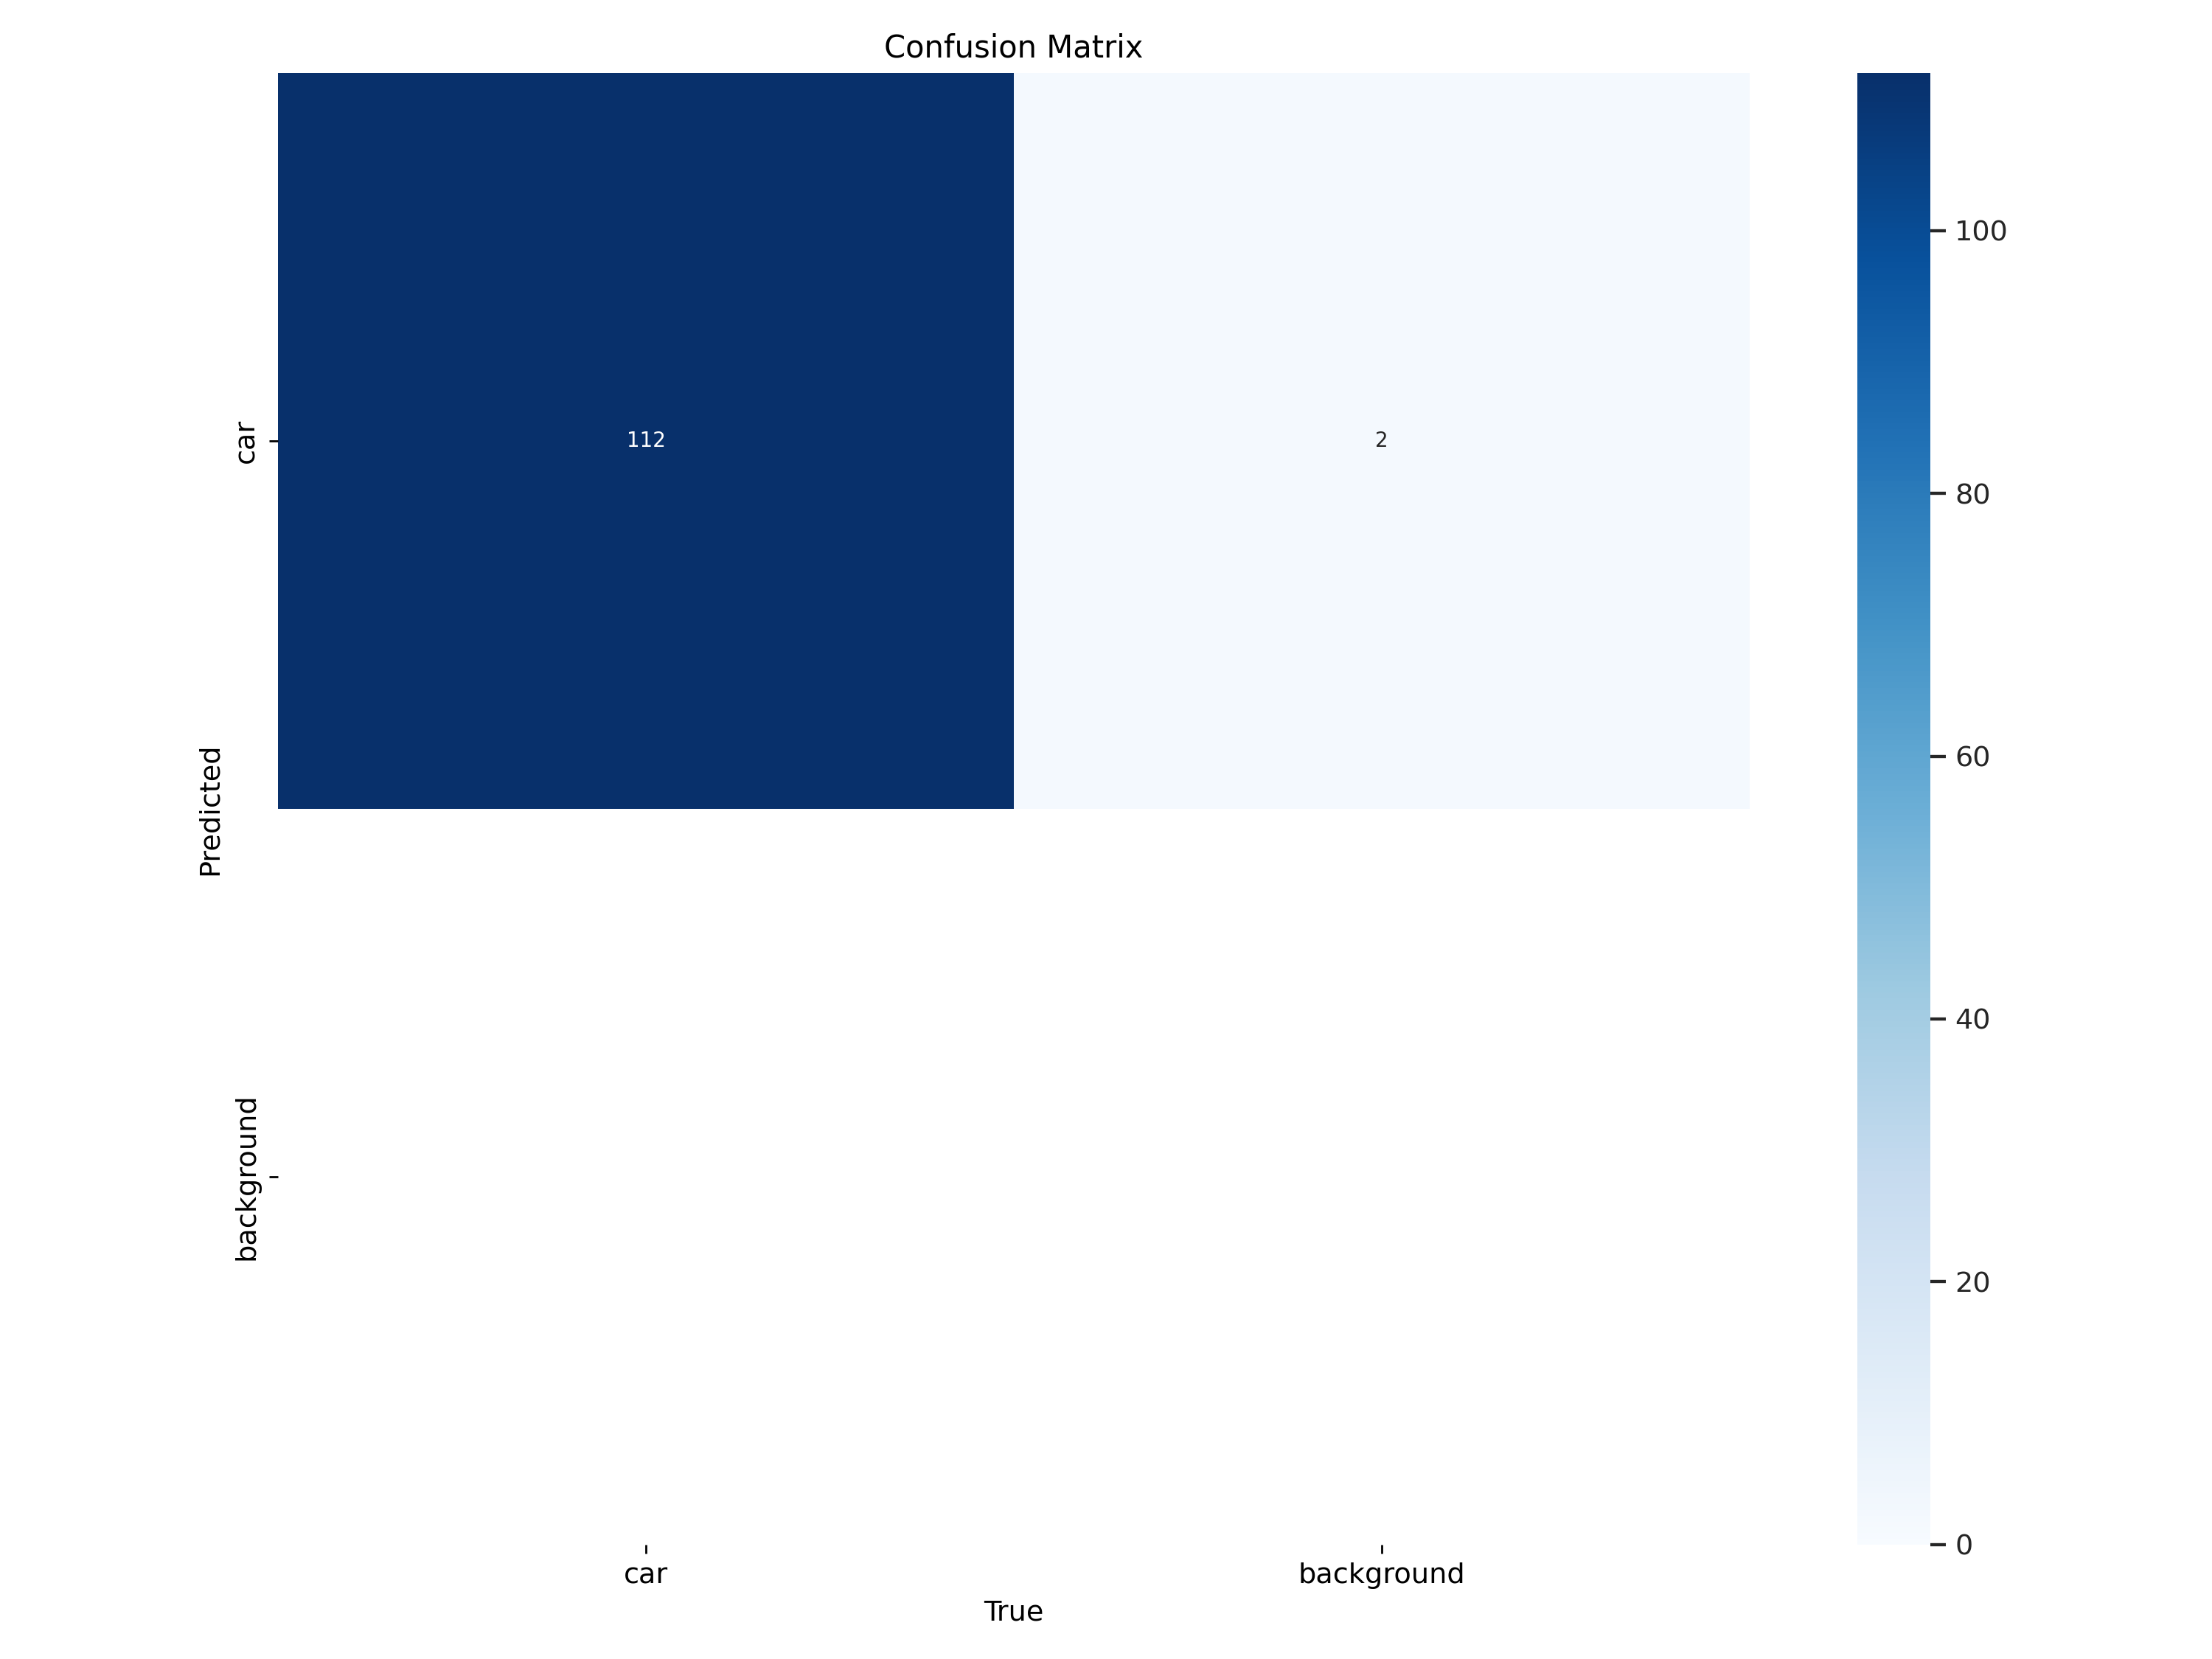

In [ ]:
Image("/content/runs/detect/train/confusion_matrix.png", width=600)

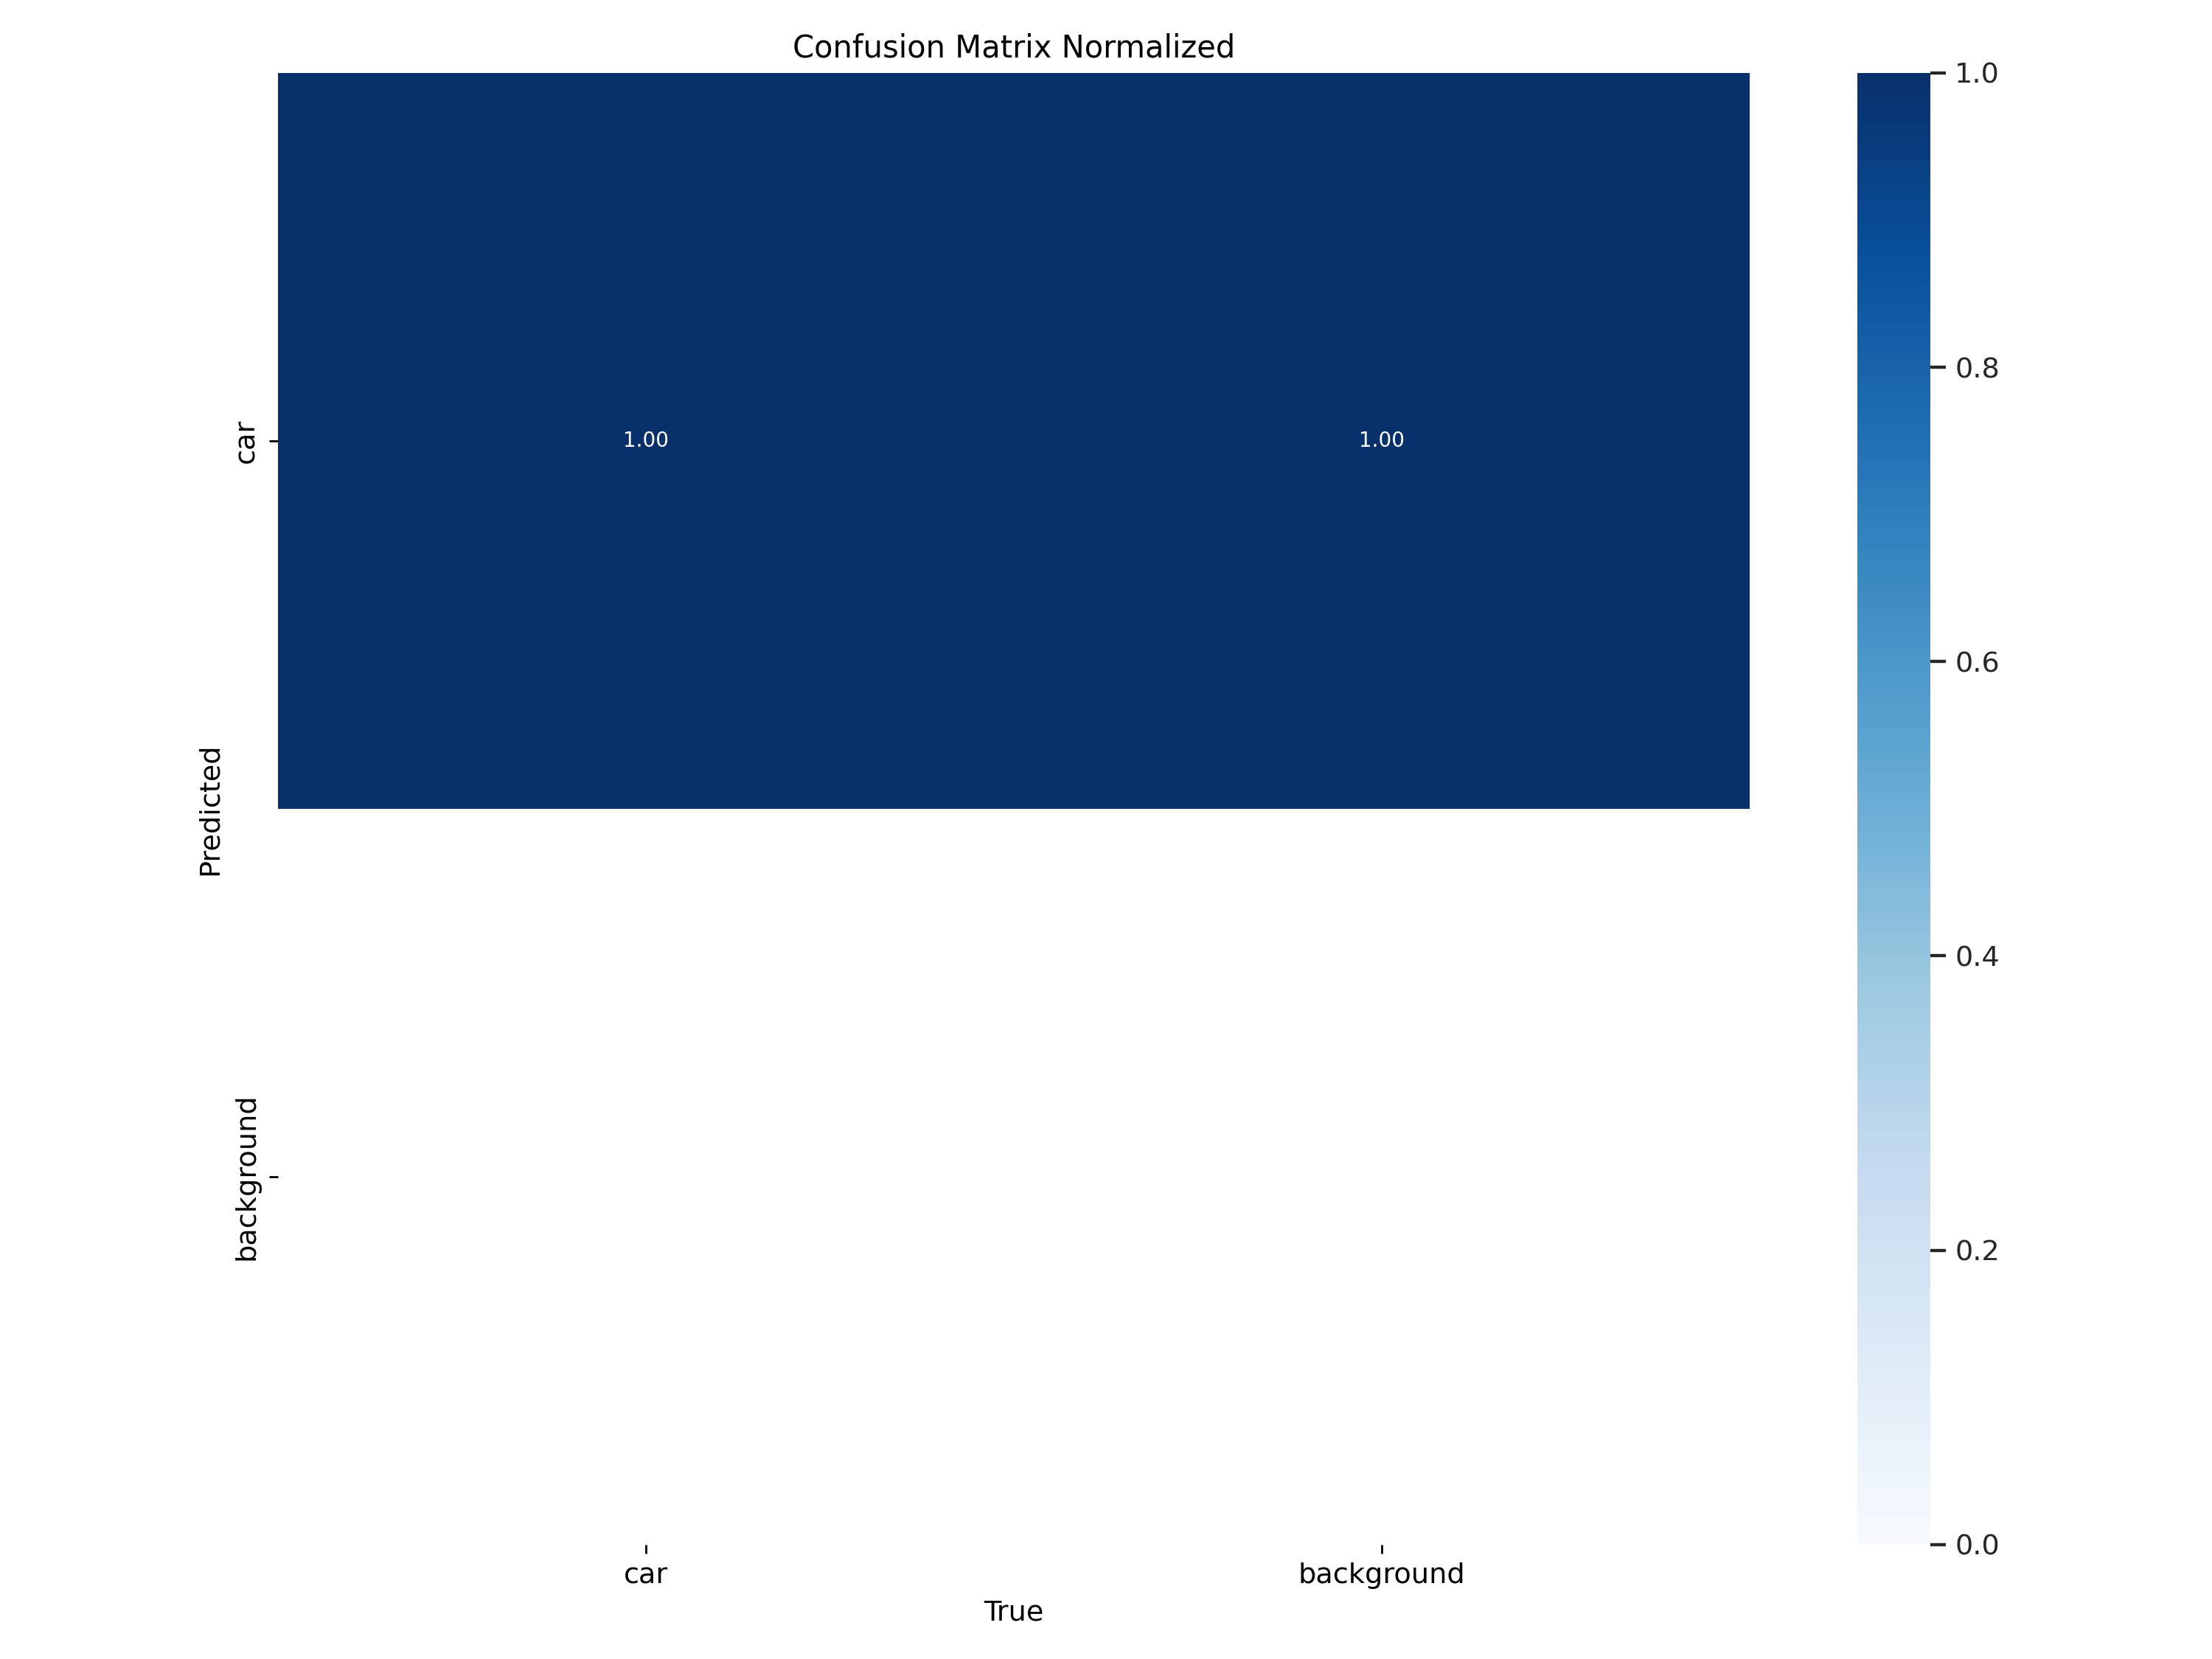

In [ ]:
Image("/content/runs/detect/train/confusion_matrix_normalized.png", width=600)

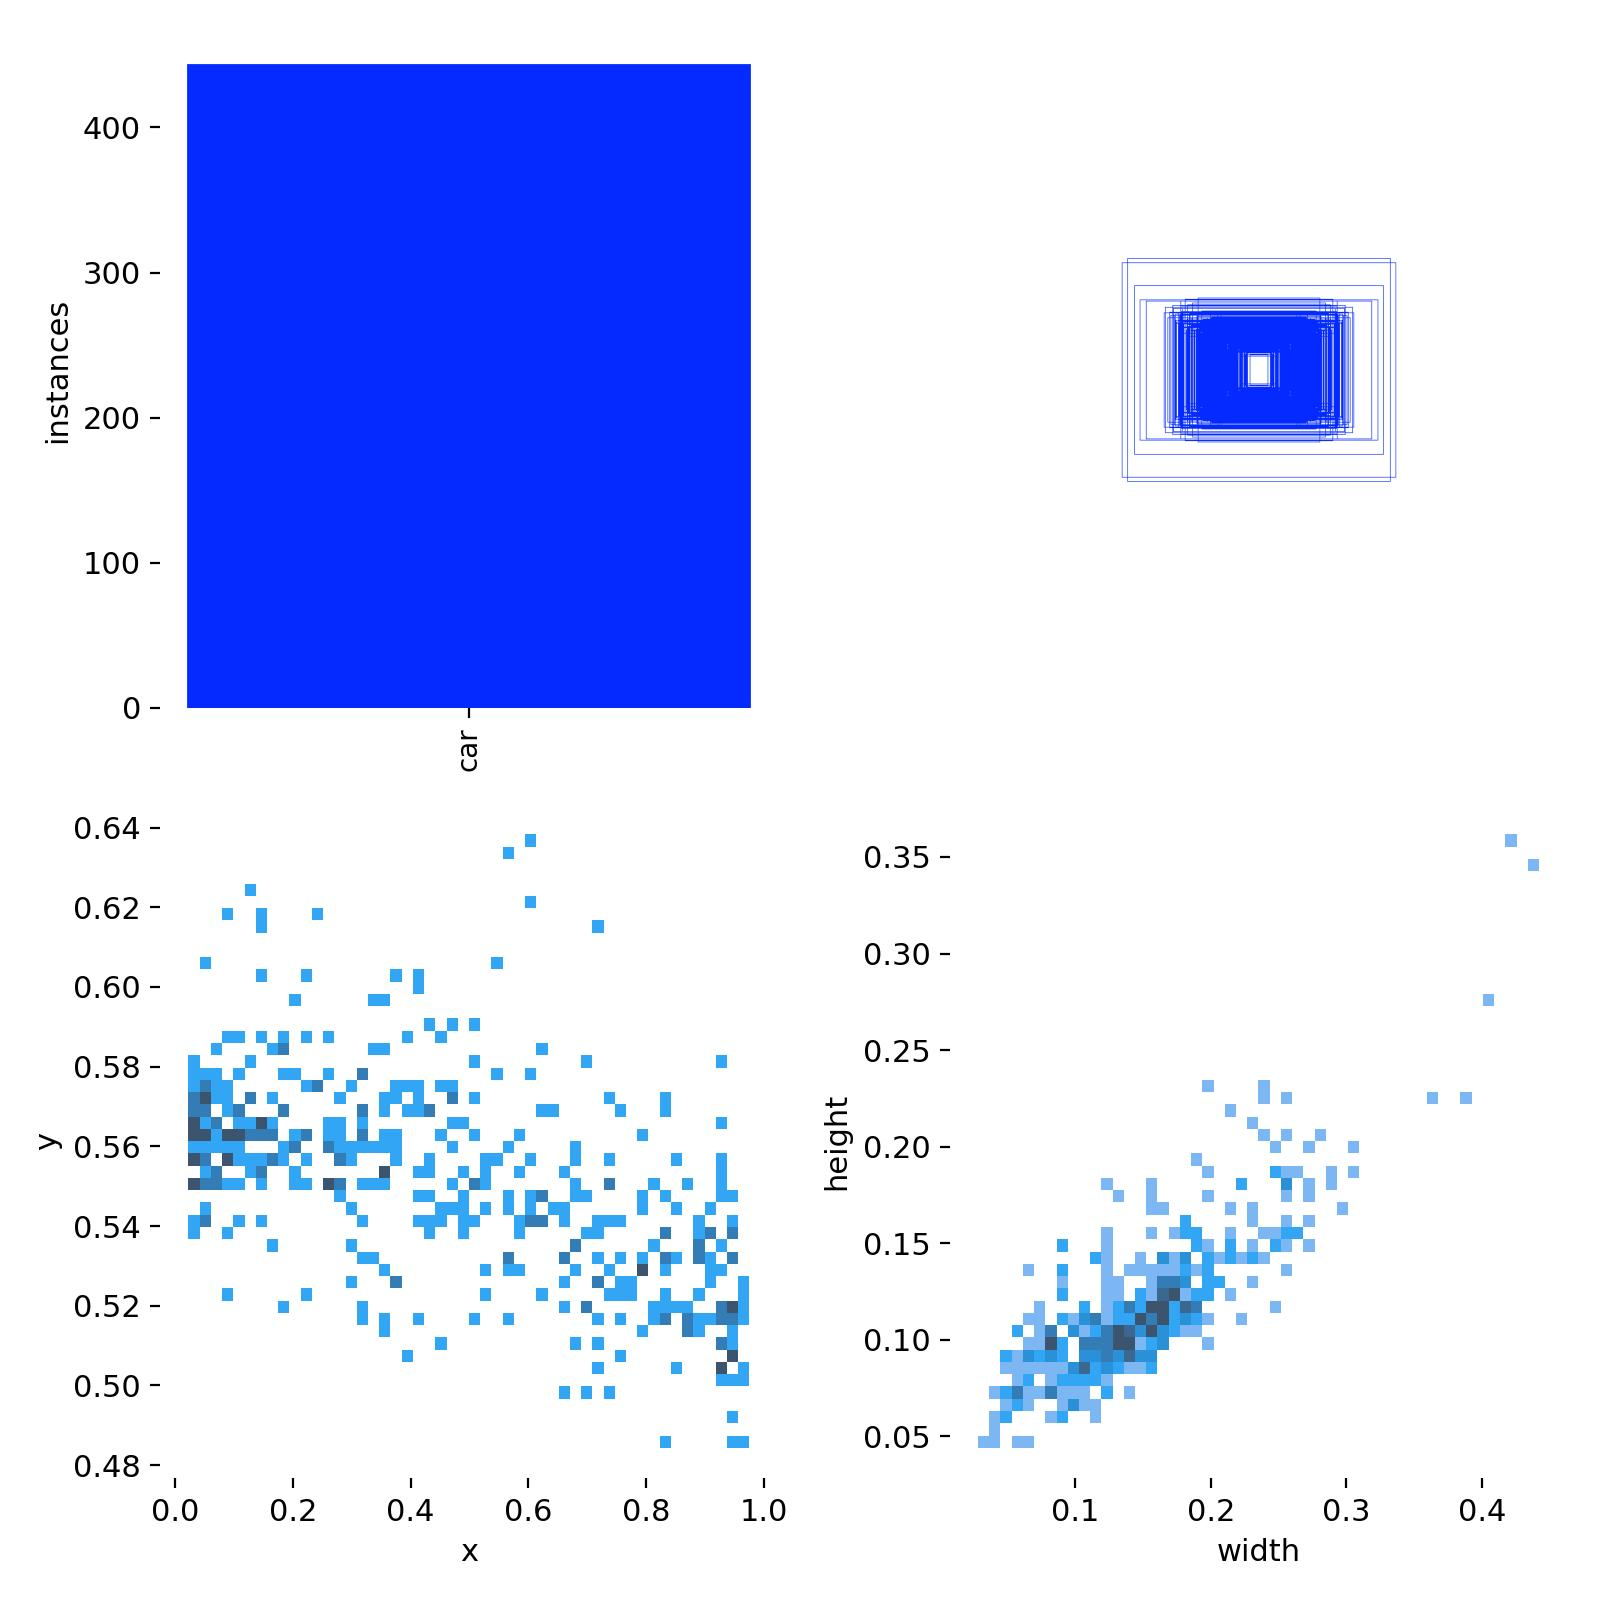

In [ ]:
Image("/content/runs/detect/train/labels.jpg", width=600)

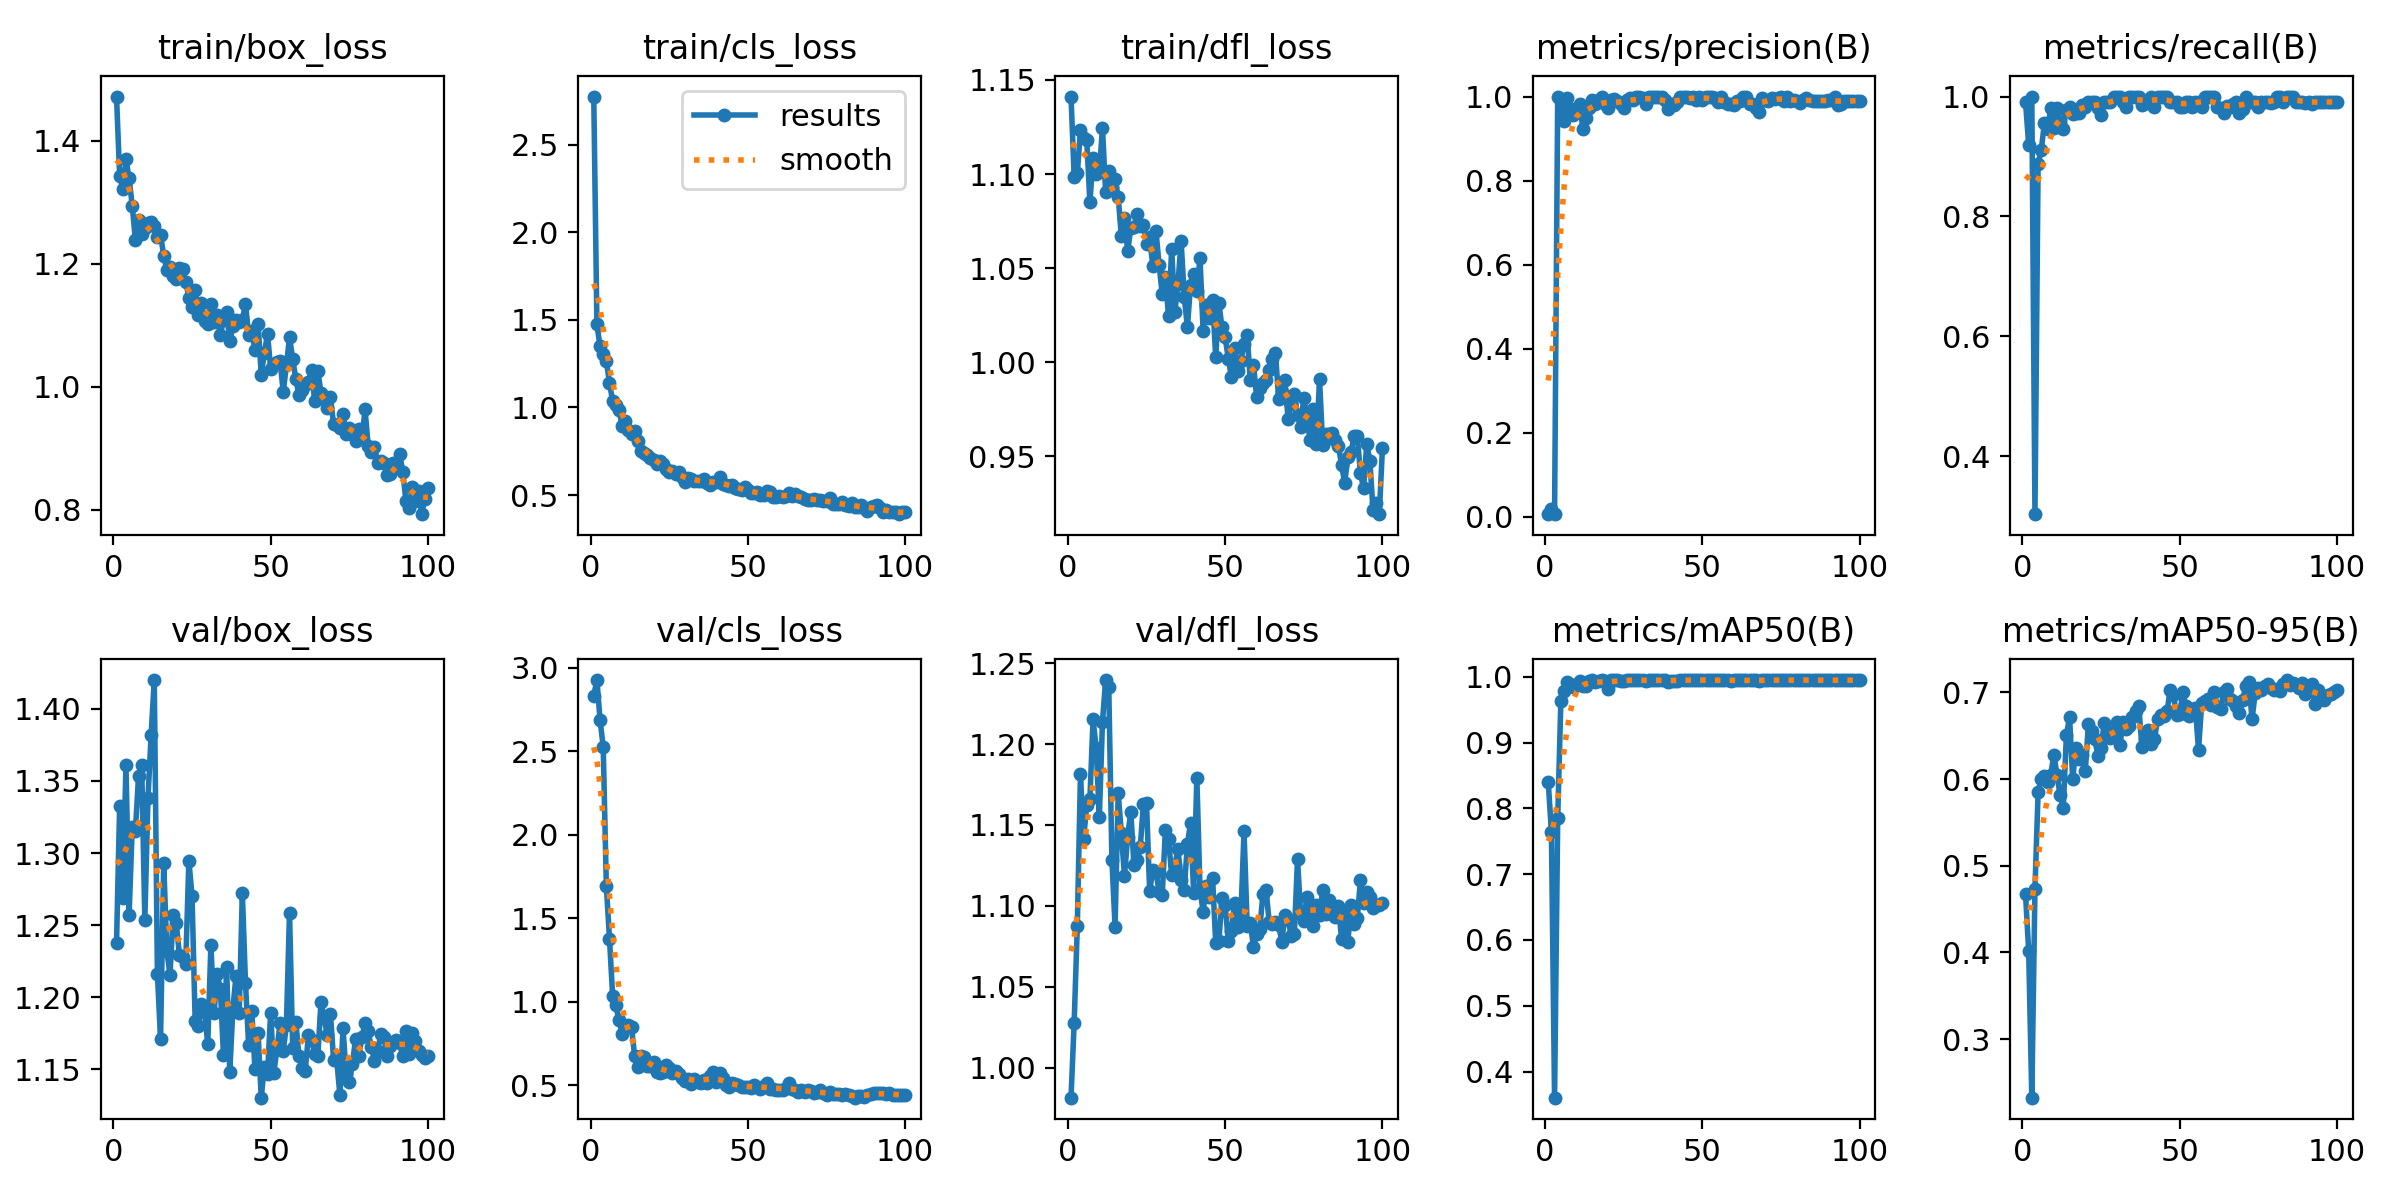

In [ ]:
Image("/content/runs/detect/train/results.png", width=600)

___

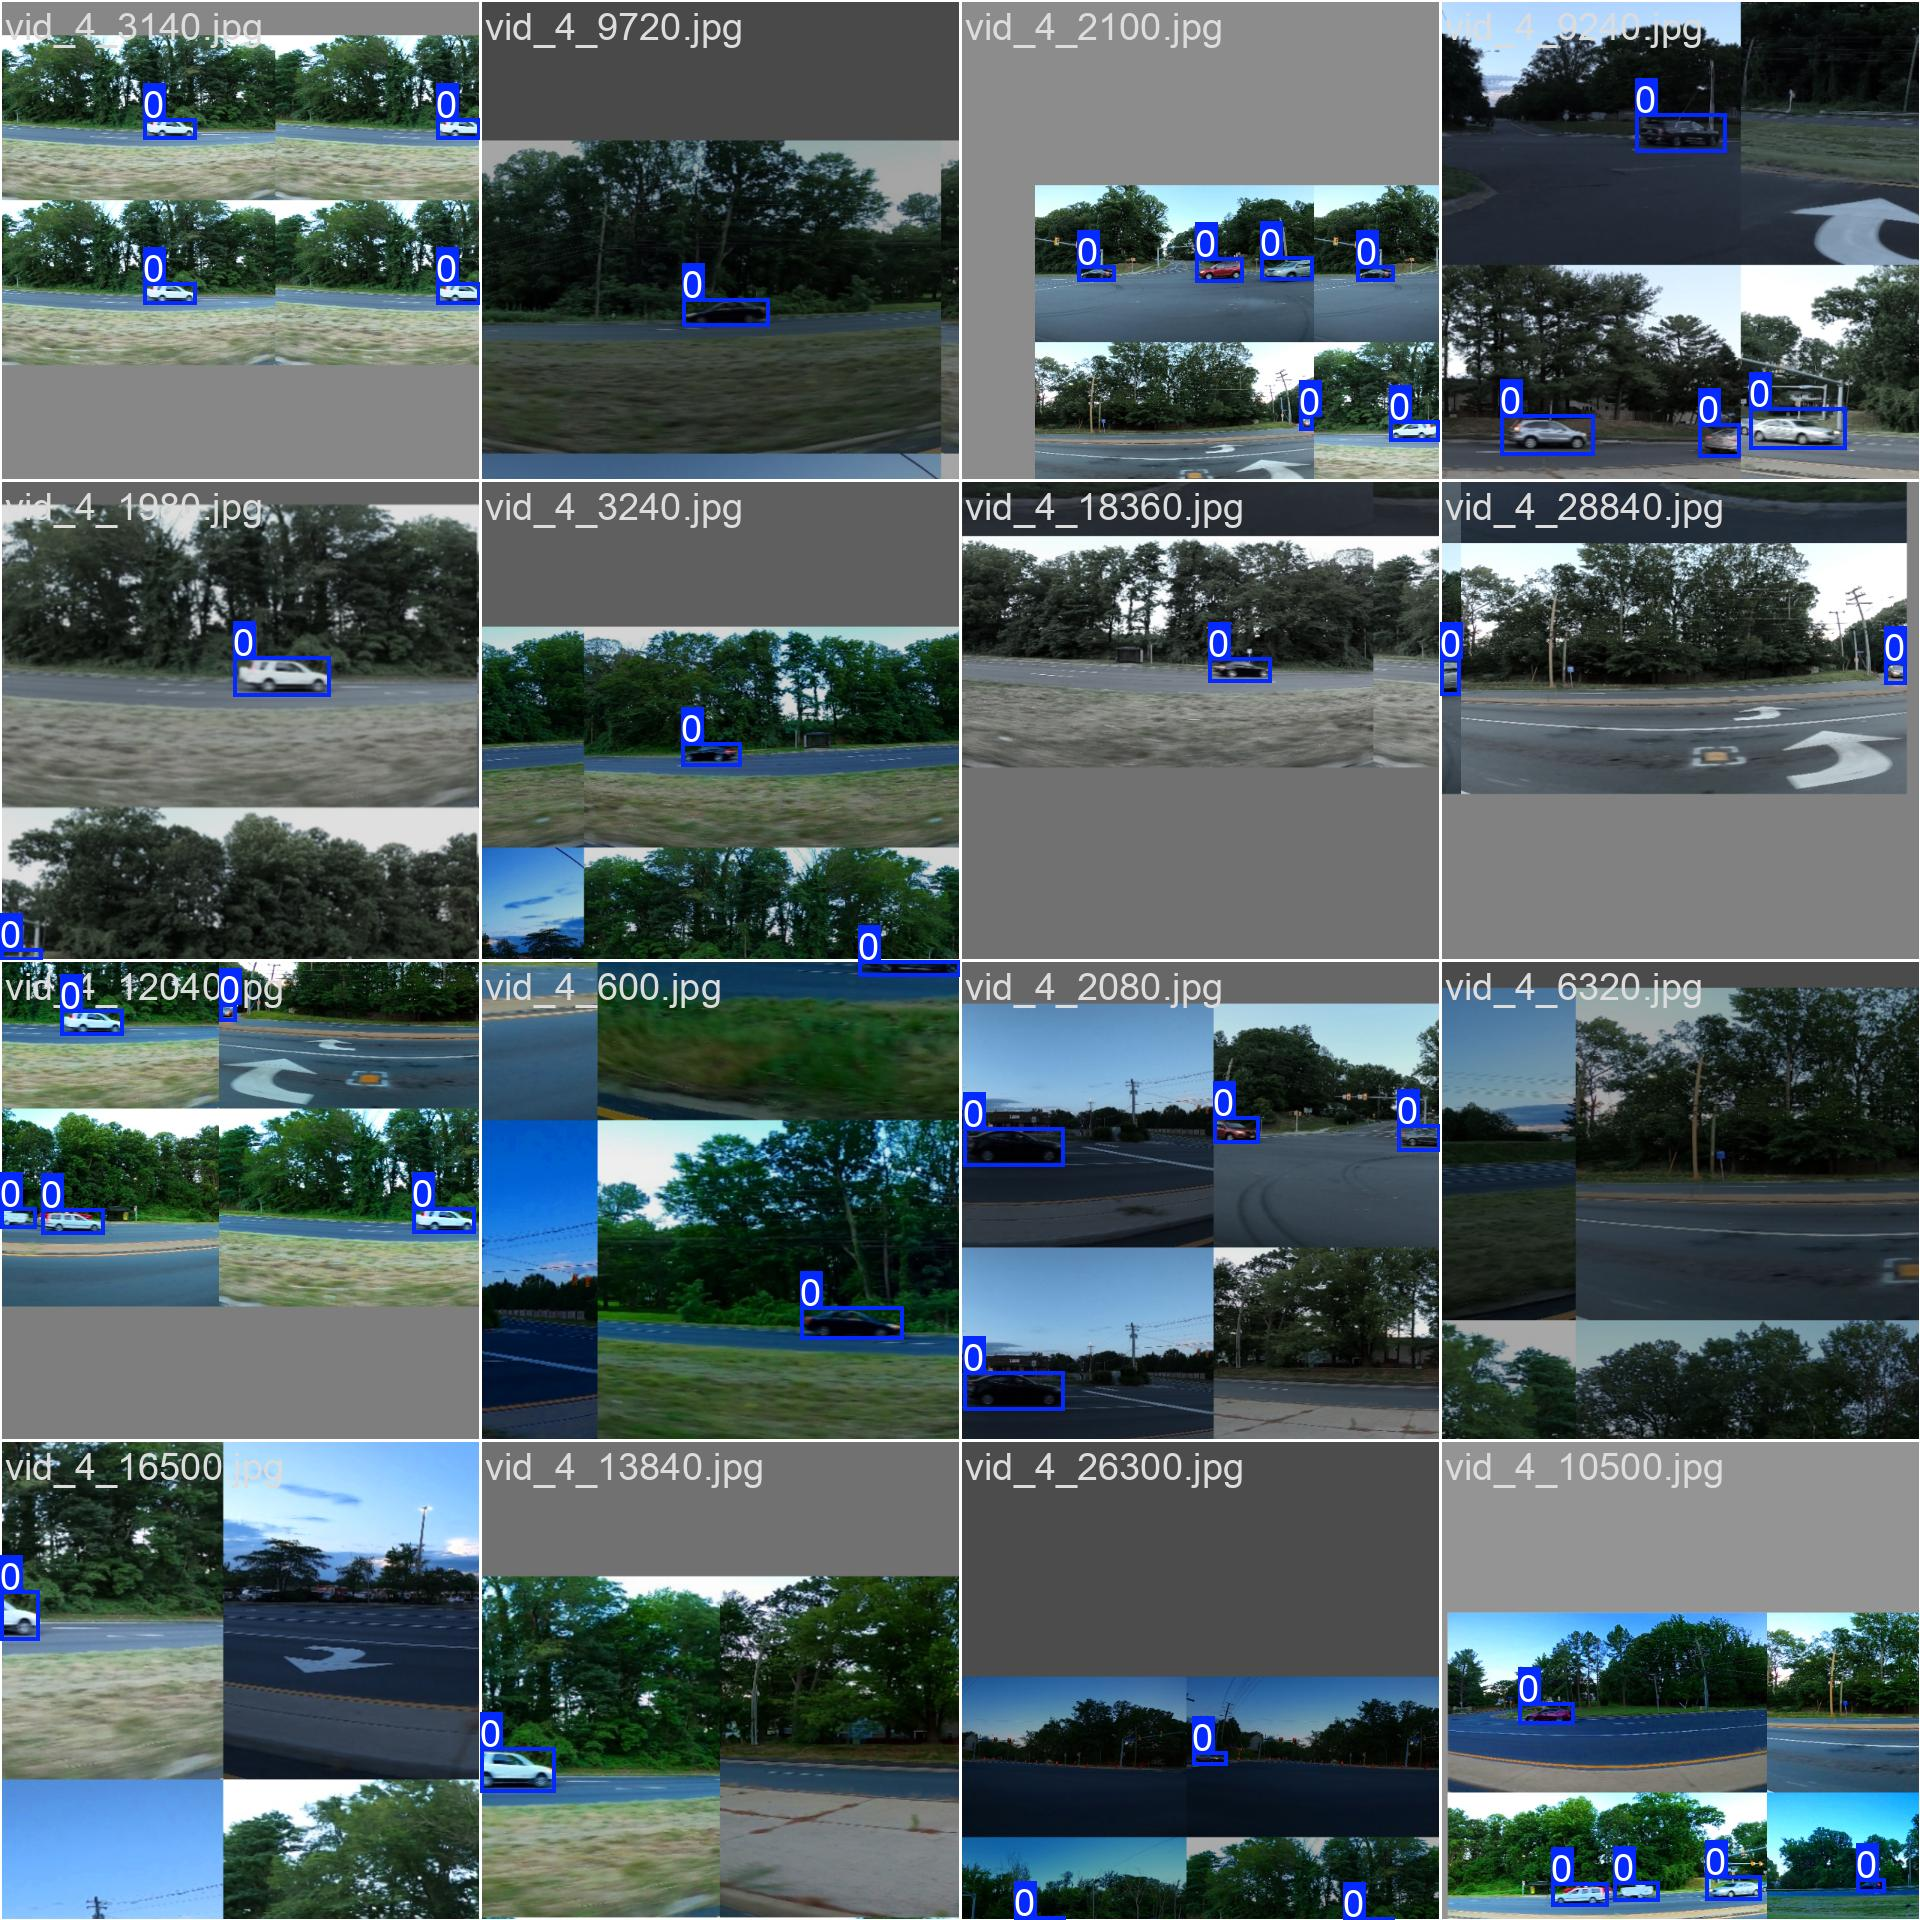

In [ ]:
Image("/content/runs/detect/train/train_batch0.jpg", width=600)

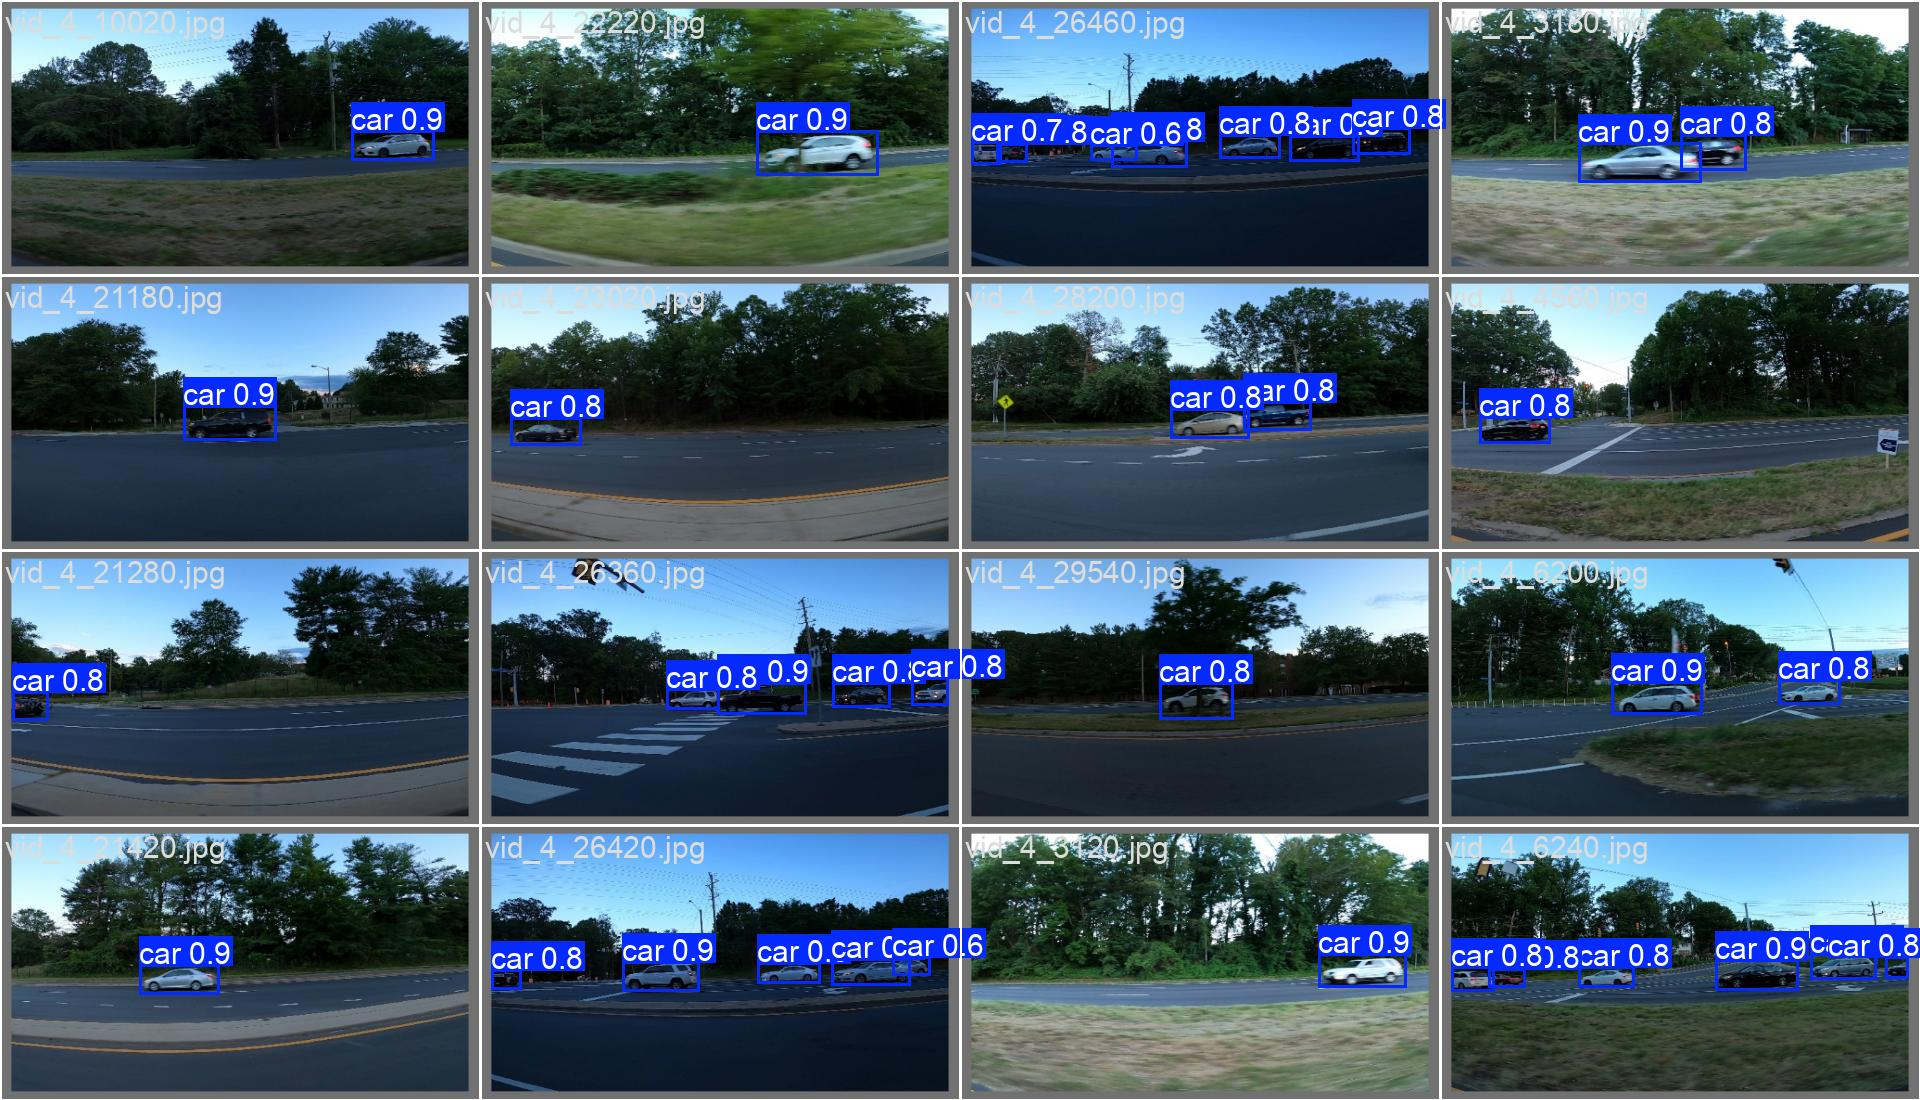

In [ ]:
Image("/content/runs/detect/train/val_batch0_pred.jpg", width=600)

In [ ]:
!yolo task=detect mode=predict model="/content/runs/detect/train/weights/best.pt" conf=0.40 source="/content/drive/MyDrive/Car Detection/images/val" save=True

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_10020.jpg: 384x640 1 car, 43.8ms
image 2/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_10060.jpg: 384x640 1 car, 11.5ms
image 3/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_12140.jpg: 384x640 2 cars, 8.3ms
image 4/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_12160.jpg: 384x640 3 cars, 8.2ms
image 5/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_12260.jpg: 384x640 2 cars, 8.0ms
image 6/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_12360.jpg: 384x640 2 cars, 7.7ms
image 7/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_12380.jpg: 384x640 (no detections), 8.2ms
image 8/61 /content/drive/MyDrive/Car Detection/images/val/vid_4_13740.jpg: 384x640 2 cars, 7.7ms
image 9/61 /content/drive/MyDrive/Car Det

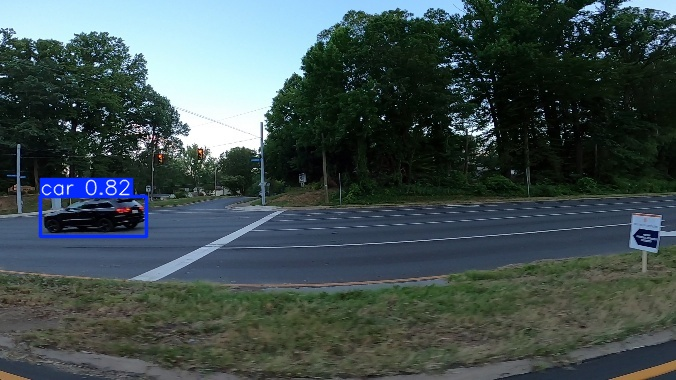

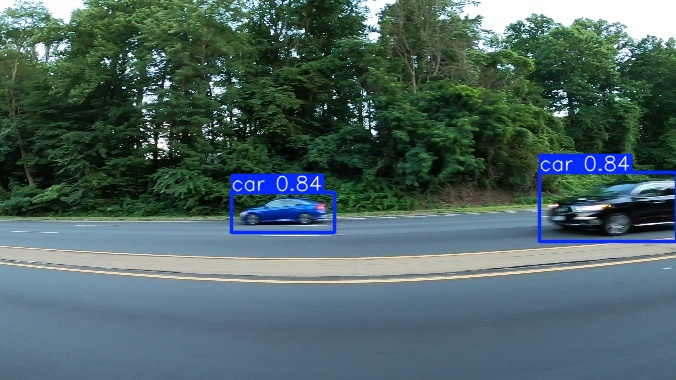

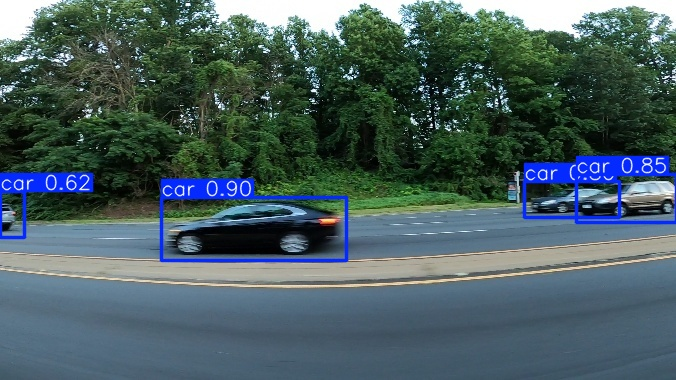

In [ ]:
from genericpath import getmtime
import glob
import os
from IPython.display import Image as IpyImage
from IPython.display import display

last_folder = max(glob.glob("/content/runs/detect/predict*/"), key=os.path.getmtime)

for img in glob.glob(last_folder + "*.jpg")[1:4]:  # [1:4] untuk gambar ke-2, ke-3, dan ke-4
    display(IpyImage(filename=img, width=600))
    print("\n")